<a href="https://colab.research.google.com/github/yhtang/SINN/blob/main/OU_SINN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

ModuleNotFoundError: No module named 'toolbox'

In [2]:
device = torch.device('cuda')

In [43]:
#### Generating SINN training data by solving Barotropic Vorticity Equation

##Wavenumbers
k = 12 * np.pi
m = 6 * np.pi
m_U = 14 * np.pi #vertical wavenumber
##

r_m = 0.1
N0_squared = 100

k_e = np.sqrt(k**2 + m**2)
k_plus = np.sqrt(k**2 +(m+m_U)**2)

W_e = np.array([[-1, k / (k_e**2)],
                [-k * N0_squared, -1]])
W_plus = np.array([[-1, -k / (k_plus**2)],
                [k * N0_squared, -1]])

W = np.block([[W_e, np.zeros((2, 2))],
             [np.zeros((2, 2)), W_plus]])

L_e = np.array([[-(k*(k_plus**2 - m_U**2)) / (2 * (k_e**2)), 0],
                [0, k / 2]])

L_plus = np.array([[-(k*(m_U**2 - k_e**2)) / (2 * (k_plus**2)), 0],
                [0, -k / 2]])

L = np.block([[np.zeros((2, 2)), L_e],
             [L_plus, np.zeros((2, 2))]])


#### Parameters 
sigma = 0.5
epsilon = 0.01                       # noise strength
gamma = 1                            # coupling constant 
dt = 0.01                            # Step-size of the SDE solver 
delta_t = 0.1                        # Step-size of the temporally coarse-grained path
batch = 400                          # Batch size 
sec_length = 500                     # Length of the input sequence 

#### SDE solver (Euler Maruyama scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length)          
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q_store = np.zeros([t_store.size+1,batch, 5]) # store 5 variables of the state
q=np.zeros((5,batch)) # 5 variables of the state
q[4,:] = 0.01  # Initial condition of U

# solve SDE
j=1
for i in range(1,length):
    # Euler Maruyama method for Barotropic Vorticity Equation
    noise_forcing = np.zeros((4, batch))
    noise_forcing[0, :] = np.sqrt(dt) * (2 * np.sqrt(2) / k_e) * np.random.randn(batch)
    psi_e = q[0,:]
    psi_p = q[2,:]
    q[0:4,:] = q[0:4,:] + dt * (W @ q[0:4,:] + q[4,:] * (L @ q[0:4,:])) + np.sqrt(epsilon) * noise_forcing
    q[4,:] = q[4,:] + dt * ((0.25 * k * (k_plus**2 - k_e**2) * psi_e * psi_p) - (r_m * q[4,:]))
    
    if i % gap ==0:            
        q_store[j,:,:]=q.T
        j=j+1

Toss=int(t_store.size/4)        
q_store=q_store[Toss:-1,:,:]         
print(q_store.shape)

250.0
(1875, 400, 5)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 1.0, 'Solution of the SDE')

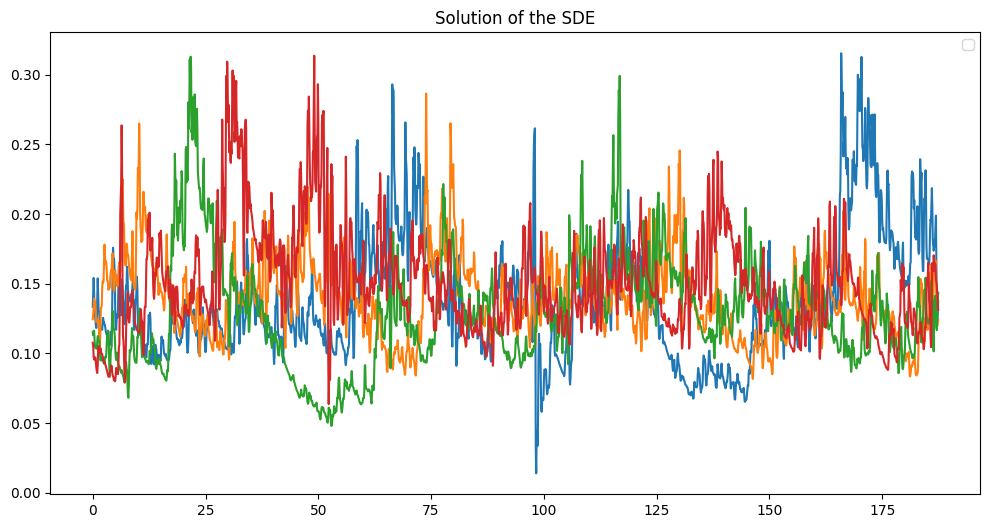

In [44]:
plt.figure(figsize=(12, 6))
for i in range(4):
    # plt.plot(t_store,q_store[:-1,i,4]) # plot the first variable of the state
    plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,i,4]) # plot the first variable of the state
plt.legend()
plt.title("Solution of the SDE")

In [45]:
#### Constructing the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch,5) # 5 variables of the state
Traj=q_store[0:sec_length,:,:]
T=np.arange(len(Traj[:,1,0]))*delta_t
print(ini.shape, Traj.shape)

(500, 400, 5) (500, 400, 5)


In [46]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(1*sec_length,batch,5).astype(np.float32) # 5 variables of the state
input = torch.from_numpy(ini).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 5), device=device) # 5 variables of the state

Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([500, 400, 5]) torch.float32
The torch validation size is torch.Size([1000, 400, 5]) torch.float32
The torch target size is torch.Size([500, 400, 5]) torch.float32


In [47]:
# Defining Loss functions
LAGS = 500
N = 500
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_q2 = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
#loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
#loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)
#loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, device=device)

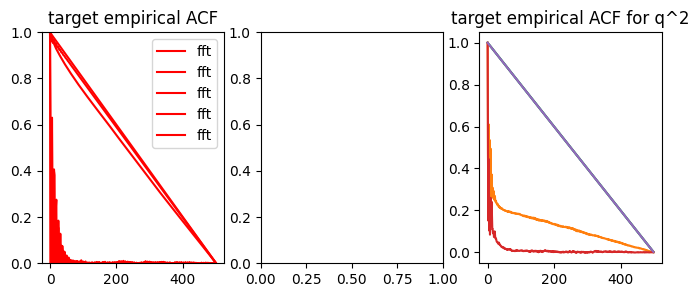

In [48]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].plot(loss_acf_fft._target.cpu(),'r', label='fft')
#axs[0].plot(loss_acf_bruteforce._target.cpu(),'b:', label='bruteforce')
axs[0].set_title('target empirical ACF')
axs[0].set_ylim([0,1])
x_grid=-np.linspace(-5,5,num=sec_length)
#axs[1].plot(loss_pdf_empirical._target.cpu(),'r--')
#axs[1].set_title('target empirical PDF')
axs[2].plot(loss_acf_q2._target.cpu())
axs[2].set_title('target empirical ACF for q^2')
axs[0].legend()
plt.show()

In [49]:
### Defining SINN model 
net = SINN(5, 10, 3, 5).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [50]:
%%time
# Training SINN
T_error=[]
V_error=[]
Step=[]
for step in range(4000):
    optimizer.zero_grad()
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = loss_acf_fft(prediction) + loss_acf_q2(prediction)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = loss_acf_fft(pred_val) + loss_acf_q2(pred_val)
            print('[%d]-th step loss: %.3f, %.3f' % (step, loss, loss_val))
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
    if loss<=0.0005 and loss_val<=0.0005:
            break
print('Training finished')

[0]-th step loss: 0.235, 0.235
[50]-th step loss: 0.107, 0.108
[100]-th step loss: 0.085, 0.083
[150]-th step loss: 0.008, 0.008
[200]-th step loss: 0.007, 0.007
[250]-th step loss: 0.007, 0.007
[300]-th step loss: 0.007, 0.007
[350]-th step loss: 0.006, 0.006
[400]-th step loss: 0.006, 0.006
[450]-th step loss: 0.006, 0.006
[500]-th step loss: 0.006, 0.006
[550]-th step loss: 0.005, 0.005
[600]-th step loss: 0.005, 0.005
[650]-th step loss: 0.005, 0.005
[700]-th step loss: 0.005, 0.005
[750]-th step loss: 0.005, 0.005
[800]-th step loss: 0.005, 0.005
[850]-th step loss: 0.005, 0.005
[900]-th step loss: 0.005, 0.005
[950]-th step loss: 0.005, 0.004
[1000]-th step loss: 0.004, 0.004
[1050]-th step loss: 0.004, 0.004
[1100]-th step loss: 0.004, 0.004
[1150]-th step loss: 0.004, 0.004
[1200]-th step loss: 0.004, 0.004
[1250]-th step loss: 0.004, 0.004
[1300]-th step loss: 0.004, 0.004
[1350]-th step loss: 0.004, 0.004
[1400]-th step loss: 0.004, 0.004
[1450]-th step loss: 0.004, 0.004
[15

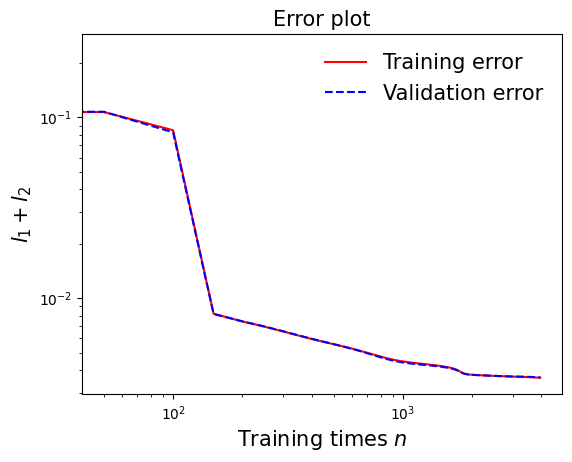

In [51]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_training_error.pdf", dpi=150)

In [52]:
# # Constructing Gaussian random input
ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
Pred,_= net(ran_input)
#prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch)

In [ ]:
prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 5)

In [53]:
print(Pred.shape)
#print(lstm_states[0].shape)

torch.Size([500, 400, 5])


In [54]:
loss_value = loss_acf_fft(Pred) + loss_acf_q2(Pred)

# Print the loss value
print(loss_value.item())

0.0036433693021535873


In [55]:
Pred_np = Pred.cpu().detach().numpy()  # Convert tensor to numpy array

In [56]:
Pred_np_avg = np.mean(Pred_np, axis=1)
print(Pred_np_avg.shape)

(500, 5)


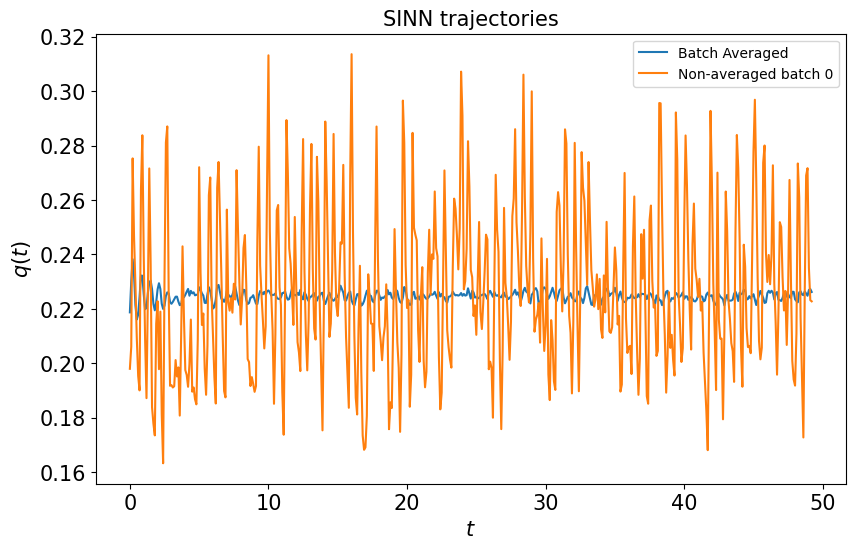

In [57]:
skip = 0
fig = plt.figure(0, figsize=(10,6))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15) 

# Plot the time evolution of each of the 5 states
for i in range(1): # Assuming there are 5 states
    plt.plot(T[skip+7:]-T[skip+7], Pred_np_avg[skip+7:, 4], label=f'Batch Averaged')
    plt.plot(T[skip+7:]-T[skip+7], Pred_np[skip+7:,0, 4], label=f'Non-averaged batch {i}')

plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
plt.legend()

In [58]:
Traj_np_avg = np.mean(Traj, axis=1)
print(Traj_np_avg.shape)

(500, 5)


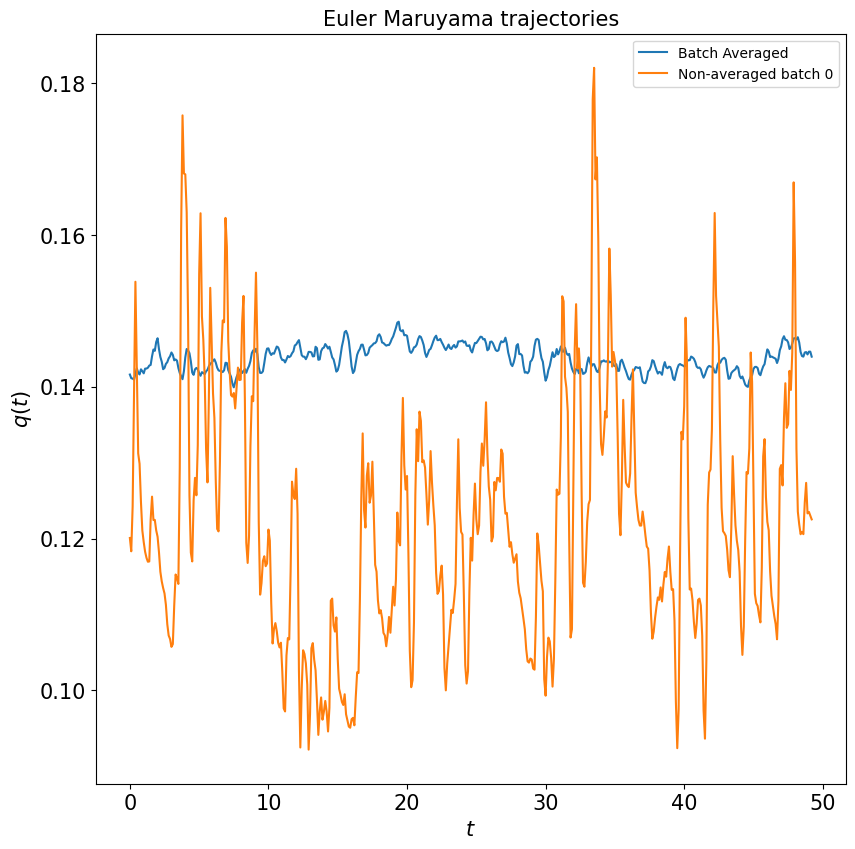

In [59]:
skip = 0

fig = plt.figure(0, figsize=(10,10))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Euler Maruyama trajectories",fontsize=15) 

# Plot the time evolution of each of the 5 states
for i in range(1):
    plt.plot(T[skip+7:]-T[skip+7], Traj_np_avg[skip+7:, 4], label=f'Batch Averaged')
    plt.plot(T[skip+7:]-T[skip+7], Traj[skip+7:, 0, 4], label=f'Non-averaged batch {i}')

#plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
plt.legend()
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

([<matplotlib.axis.YTick at 0x7f66f45963e0>,
 [Text(0, -2.0, '−2.0'),
  Text(0, -1.5, '−1.5'),
  Text(0, -1.0, '−1.0'),
  Text(0, -0.5, '−0.5'),
  Text(0, 0.0, '0.0'),
  Text(0, 0.5, '0.5'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.5, '1.5'),
  Text(0, 2.0, '2.0')])

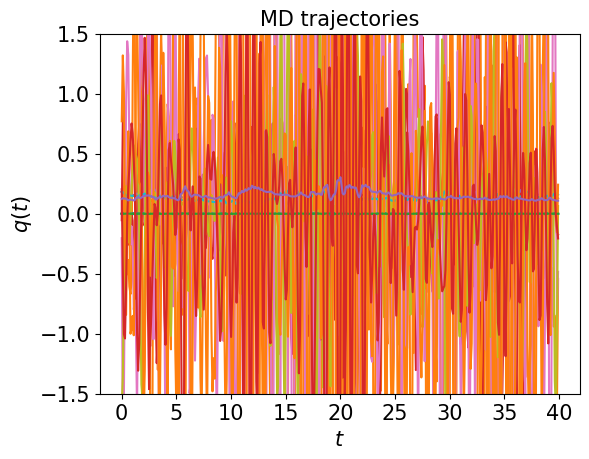

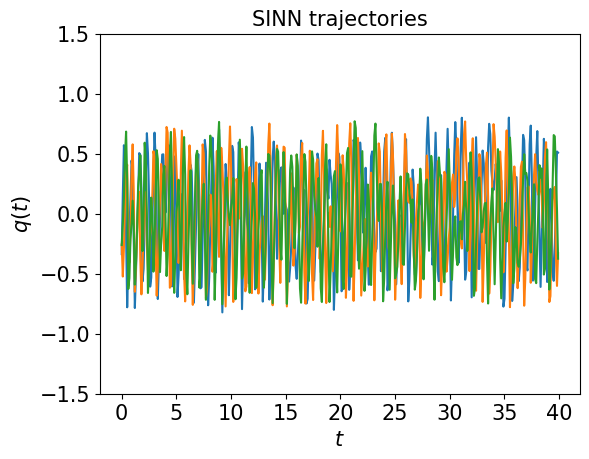

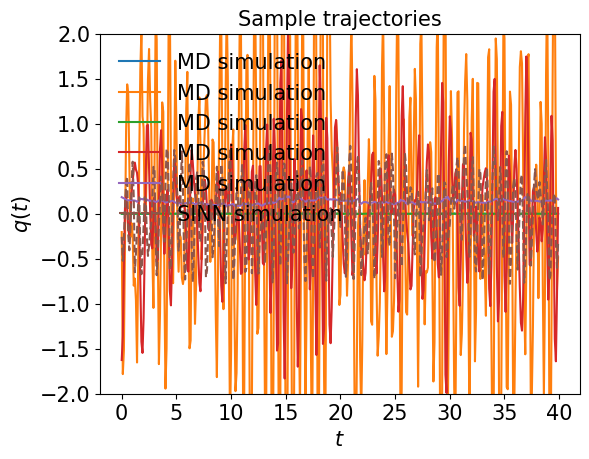

In [37]:
# Test 1: plot the sample path generated by SINN and the exact sample path 
skip = 0

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("MD trajectories",fontsize=15) 
plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
plt.plot(T[skip:]-T[skip], Traj[skip:, 1])
plt.plot(T[skip:]-T[skip], Traj[skip:, 2])   
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)     
# plt.savefig("figs/OU_traj_multi_MD.pdf", dpi=150)

fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("SINN trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
plt.plot(T[skip:]-T[skip], prediction[skip:, 1])
plt.plot(T[skip:]-T[skip], prediction[skip:, 2])
plt.ylim([-1.5,1.5])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_traj_multi.pdf", dpi=150)

fig = plt.figure(2)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Sample trajectories",fontsize=15)    
plt.plot(T[skip:]-T[skip], Traj[skip:, 1], label='MD simulation')
plt.plot(T[skip:]-T[skip], prediction[skip:, 1],'--',label='SINN simulation')
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-2,-1.5,-1,-0.5,0,0.5,1,1.5,2.0],fontsize=15)
# plt.savefig("figs/OU_traj.pdf", dpi=150)

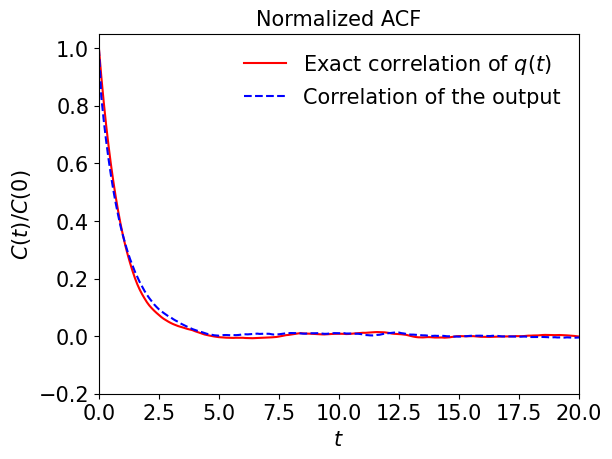

In [20]:
# Test 2: plot the ACF of the sample path generated by the SINN and the exact ACF 


acf_p=StatLoss.acf(Pred[-sec_length:,:,:])
acf_t=StatLoss.acf(target)
corr_p=acf_p.mean(axis=1).detach().cpu().numpy()
corr_t=acf_t.mean(axis=1).detach().cpu().numpy()


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, corr_t,'r',label=r'Exact correlation of $q(t)$')        # correlation function of the target 
plt.plot(T, corr_p, 'b--',label=r'Correlation of the output')        # Correlation function after the training      # Correlation function after the training 
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0,20)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf.pdf", dpi=150)

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 [Text(0, 0.0, '0.00'),
  Text(0, 0.25, '0.25'),
  Text(0, 0.5, '0.50'),
  Text(0, 0.75, '0.75'),
  Text(0, 1.0, '1.00'),
  Text(0, 1.25, '1.25'),
  Text(0, 1.5, '1.50'),
  Text(0, 1.75, '1.75'),
  Text(0, 2.0, '2.00')])

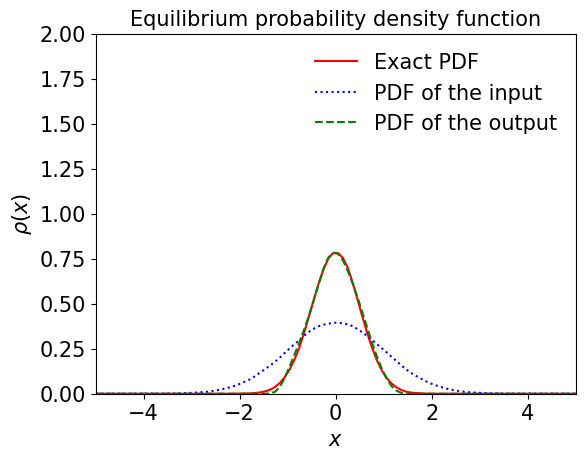

In [21]:
# Test 3: plot the PDF of the sample path generated by SINN and the exact PDF 

rho_data =  StatLoss.gauss_kde(target, -5, 5, 100).cpu()
rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100).cpu()
rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100).cpu()

x=np.linspace(-5, 5, 100)
fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r"Equilibrium probability density function",fontsize=15)    
plt.plot(x, rho_data.numpy(), 'r',label=r'Exact PDF')    # target PDF
plt.plot(x, rho_input.numpy(), 'b:', label=r'PDF of the input')     # PDF of the input
plt.plot(x, rho_prediction.numpy(), 'g--',label=r'PDF of the output')  # PDF after the training 
plt.xlim(-5,5)
plt.ylim(0,2)
plt.xlabel(r'$x$',fontsize=15)
plt.ylabel(r'$\rho(x)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig("figs/OU_pdf.pdf", dpi=150)

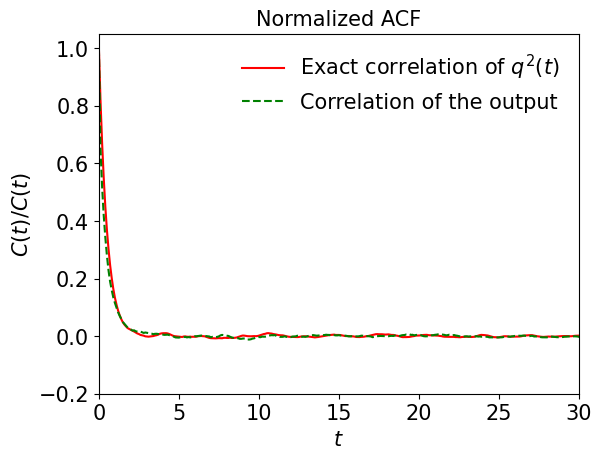

In [22]:
# Test 4: Comparing the higher-order ACF
acf2=StatLoss.acf(target**2)
pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,1))
acf2_app=StatLoss.acf(pred_norm**2)

fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title(r'Normalized ACF',fontsize=15)    
plt.plot(T, acf2.mean(axis=1).detach().cpu().numpy(),'r',label=r'Exact correlation of $q^2(t)$')        # Exact correlation function 
plt.plot(T, acf2_app.mean(axis=1).detach().cpu().numpy(), 'g--',label=r'Correlation of the output')        # Correlation function after the training 
plt.xlim(0,30)
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$C(t)/C(t)$',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
plt.legend(frameon=False,fontsize=15)
# plt.savefig("figs/OU_acf2.pdf", dpi=150)

(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500')])

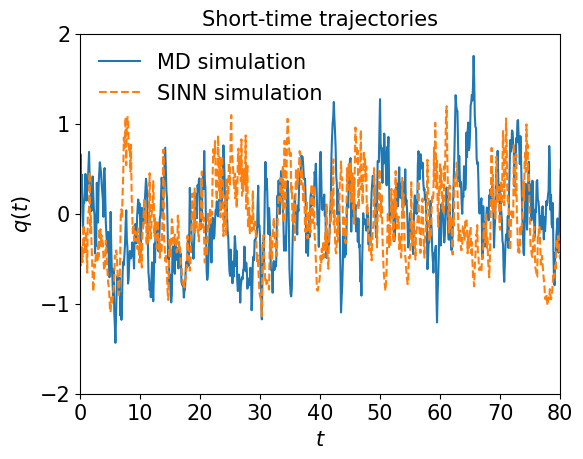

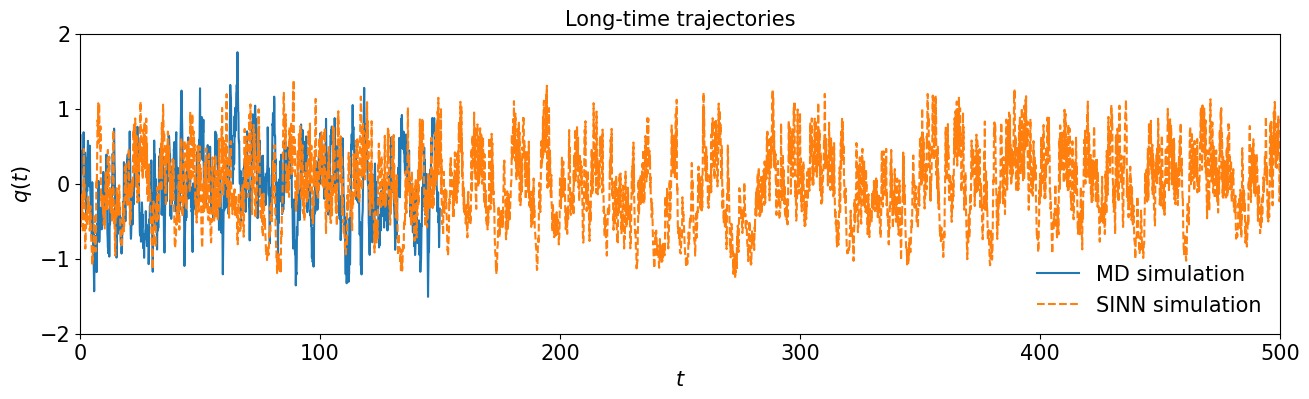

In [23]:
# Test 5: plot the expolation result, i.e. Prediction of the OU dynamics for longer time 

[a,b,c]=input.size()
skip=20
scale=10
burnin=3
fold=800
batch_new=50
ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
Pred_L, _= net(ran_input)
prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new)
acf_p=StatLoss.acf(Pred_L,method='bruteforce')

LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
LT=LT[0:-1]


fig = plt.figure(0)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Short-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,80])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_sT.pdf", dpi=150)


fig = plt.figure(figsize=(16, 4))
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Long-time trajectories",fontsize=15)
plt.plot(t_store[Toss:]-t_store[Toss],q_store[:,0],label='MD simulation')
plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 1],'--',label='SINN simulation')
plt.xlim([0,500])
plt.ylim([-2,2])
plt.xlabel(r'$t$',fontsize=15)
plt.ylabel(r'$q(t)$',fontsize=15)
plt.legend(frameon=False,fontsize=15)
plt.yticks([-2,-1,0,1,2],fontsize=15)
plt.xticks(fontsize=15)
# plt.savefig("figs/OU_traj_lT.pdf", dpi=150)

# END